In [17]:
import os
import sys
import json
from tqdm import tqdm_notebook as tqdm
from pprint import pprint

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
import japanize_matplotlib
import seaborn as sns

## data load

In [3]:
ls ../mnt/inputs/origin/

data-science-bowl-2019.zip  specs.csv  train.csv     train_labels.csv
sample_submission.csv       test.csv   train.pkl.gz


In [4]:
# trn_df = pd.read_csv('../mnt/inputs/origin/train.csv')
trn_df = pd.read_pickle('../mnt/inputs/origin/train.pkl.gz')
trn_labels_df = pd.read_csv('../mnt/inputs/origin/train_labels.csv')
specs_df = pd.read_csv('../mnt/inputs/origin/specs.csv')
tst_df = pd.read_csv('../mnt/inputs/origin/test.csv')
sub_df = pd.read_csv('../mnt/inputs/origin/sample_submission.csv')

In [4]:
display(trn_df.shape, trn_df.head())

(11341042, 11)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [10]:
display(trn_labels_df.shape, trn_labels_df.head())

(17690, 7)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [6]:
display(tst_df.shape, tst_df.head())

(1156414, 11)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [7]:
display(sub_df.shape, sub_df.head())

(1000, 2)

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [8]:
# 重いので train のみ pkl 化
# trn_df.to_pickle('../mnt/inputs/origin/train.pkl.gz', compression='gzip')

## EDA

In [11]:
trn_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [47]:
trn_df.event_data.iloc[4]

'{"description":"Let\'s build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!","identifier":"Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape","media_type":"audio","duration":6919,"event_count":3,"game_time":6972,"event_code":3110}'

#### yamakawa-san method の確認

In [ ]:
trn_df[
    (
            (trn_df.event_code == 4100)
        & (trn_df.title != "Bird Measurer (Assessment)")
    )
]

In [26]:
label_tst_df = tst_df[
    (
            (tst_df.event_code == 4100)
        & (tst_df.title != "Bird Measurer (Assessment)")
    )
    | (
            (tst_df.event_code == 4110)
        & (tst_df.title == "Bird Measurer (Assessment)")
    ) 
]
display(label_tst_df.shape, label_tst_df.head())

(8123, 11)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
303,d122731b,8b38fc0d2fd315dc,2019-09-11T18:56:34.661Z,"{""correct"":true,""left"":[{""id"":""gem07"",""weight""...",00abaee7,22,4100,22737,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
1561,392e14df,009c890ce6c4f3e3,2019-09-22T21:23:17.737Z,"{""buckets"":[0,0,0],""correct"":false,""buckets_pl...",01242218,15,4100,11474,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1569,392e14df,009c890ce6c4f3e3,2019-09-22T21:23:26.033Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",01242218,22,4100,19775,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1961,d122731b,e8e62de939f916bc,2019-09-22T21:39:06.838Z,"{""correct"":true,""left"":[{""id"":""gem07"",""weight""...",01242218,9,4100,8504,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
2016,a5e9da97,16a00888451f6ff7,2019-09-22T21:43:02.917Z,"{""scale_weights"":2,""target_weight"":3,""table_we...",01242218,9,4100,18255,Pan Balance,Game,CRYSTALCAVES


In [27]:
label_tst_df.type.value_counts()

Assessment    4492
Game          3631
Name: type, dtype: int64

In [31]:
label_tst_df.query('type == "Assessment"').game_session.nunique()

2018

In [33]:
display(sub_df.shape, sub_df.head())

(1000, 2)

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [36]:
tst_df.query('type == "Assessment"').game_session.nunique()

3347

In [6]:
label_trn_df = trn_df[
    (
            (trn_df.event_code == 4100)
        & (trn_df.title != "Bird Measurer (Assessment)")
    )
    | (
            (trn_df.event_code == 4110)
        & (trn_df.title == "Bird Measurer (Assessment)")
    ) 
]
display(label_trn_df.shape, label_trn_df.head())

(78446, 11)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2228,25fa8af4,901acc108f55a5a1,2019-08-06T05:22:32.357Z,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2308,14de4c5d,80d34a30c2998653,2019-08-06T05:24:50.323Z,"{""distance"":10,""target_distances"":[5,6,7,8,9,1...",0006a69f,76,4100,114370,Air Show,Game,TREETOPCITY
2335,14de4c5d,80d34a30c2998653,2019-08-06T05:25:11.292Z,"{""distance"":9,""target_distances"":[5,6,7],""corr...",0006a69f,103,4100,135341,Air Show,Game,TREETOPCITY
2375,14de4c5d,80d34a30c2998653,2019-08-06T05:25:37.207Z,"{""distance"":3,""target_distances"":[5,6,7],""corr...",0006a69f,143,4100,161258,Air Show,Game,TREETOPCITY
2409,14de4c5d,80d34a30c2998653,2019-08-06T05:26:01.055Z,"{""distance"":8,""target_distances"":[5,6,7],""corr...",0006a69f,177,4100,185103,Air Show,Game,TREETOPCITY


In [11]:
trn_labels_df.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


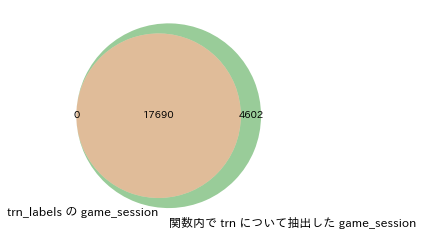

In [18]:
venn2([set(trn_labels_df.game_session), set(label_trn_df.game_session)], set_labels=['trn_labels の game_session', '関数内で trn について抽出した game_session'])

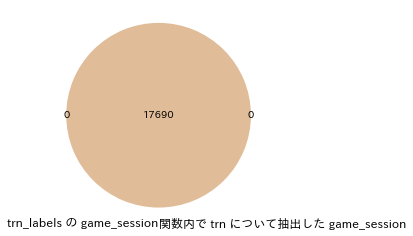

In [25]:
venn2([set(trn_labels_df.game_session), set(label_trn_df.query('type == "Assessment"').game_session)], set_labels=['trn_labels の game_session', '関数内で trn について抽出した game_session'])

In [20]:
set(label_trn_df.game_session) - set(trn_labels_df.game_session)

{'bb0765148d500ee5',
 '1cbfda5b1ed65477',
 '063cd0afc39096cc',
 'a9ad2139f85054dc',
 'bddef20f6bf08444',
 '5c12bf78753841a8',
 'de82f0ac0040ed0e',
 'e0c2aecabccc4e5e',
 'f06729ecd64da329',
 '8441dd345cef4998',
 '51b242a2016e1962',
 '5945d88145f5c81d',
 '865538d76bea55fa',
 '9718abe7e66c81bd',
 'ac53030f34f5a5f4',
 '2a60fa145ccb04c8',
 '103d1e31fa194412',
 '077f201049391390',
 '61b18526b4d4a910',
 '143942e9a83a4cb9',
 '6ae3f1b52f92b8e6',
 '1abe7d440c4f328d',
 '1dec538a0b00e8be',
 '89eef49813d0fbfe',
 'f3247f5e9d7be383',
 '152888dd448bf3ba',
 'f807acfda837a4e8',
 '259cf33829dec7f3',
 '308473e6b3745d4e',
 '257b038a5cca6d35',
 '7fbba27f32fb98c4',
 '930f8439d9535f13',
 '5f3f607480074fdd',
 '543aafcb3a7727a4',
 '94d033af2d678ecd',
 '2917ff1a02bbd946',
 '69a74e6d12416aba',
 '2aa083d2d8cdb0af',
 'a28bd7e4732354ce',
 'acd203553f86a395',
 '58f9901325c8fdb0',
 '4690a080aa462cb9',
 '6a2b606f1a9ed3a7',
 'bcf6a448f7e94c51',
 'bd1ce0cb4fc94ab6',
 '228274c9dcedac95',
 'baa0e6372bc34edc',
 '5e2afaf4a30

In [24]:
label_trn_df.type.value_counts()

Assessment    41549
Game          36897
Name: type, dtype: int64

In [24]:
label_trn_df.type.value_counts()

Assessment    41549
Game          36897
Name: type, dtype: int64

In [22]:
tst_df.type.value_counts()

Game          572260
Activity      466274
Assessment    102627
Clip           15253
Name: type, dtype: int64

In [21]:
trn_df.query('game_session == "bb0765148d500ee5"')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
10527363,15ba1109,bb0765148d500ee5,2019-07-27T21:15:18.832Z,"{""version"":""1"",""round"":0,""event_count"":1,""game...",eeac9a73,1,2000,0,Air Show,Game,TREETOPCITY
10527364,65abac75,bb0765148d500ee5,2019-07-27T21:15:22.302Z,"{""coordinates"":{""x"":845,""y"":296,""stage_width"":...",eeac9a73,2,4010,3509,Air Show,Game,TREETOPCITY
10527365,06372577,bb0765148d500ee5,2019-07-27T21:15:27.990Z,"{""round"":0,""event_count"":3,""game_time"":9190,""e...",eeac9a73,3,2060,9190,Air Show,Game,TREETOPCITY
10527366,f28c589a,bb0765148d500ee5,2019-07-27T21:15:28.009Z,"{""description"":""First, click the space where y...",eeac9a73,4,3010,9190,Air Show,Game,TREETOPCITY
10527367,a1bbe385,bb0765148d500ee5,2019-07-27T21:15:32.466Z,"{""description"":""First, click the space where y...",eeac9a73,5,3110,13693,Air Show,Game,TREETOPCITY
...,...,...,...,...,...,...,...,...,...,...,...
10527559,a1bbe385,bb0765148d500ee5,2019-07-28T02:12:32.687Z,"{""description"":""You moved your dinosaur Ten sp...",eeac9a73,197,3110,1312494,Air Show,Game,TREETOPCITY
10527560,14de4c5d,bb0765148d500ee5,2019-07-28T02:12:34.568Z,"{""distance"":10,""target_distances"":[1,2,3,4,5,6...",eeac9a73,198,4100,1314358,Air Show,Game,TREETOPCITY
10527561,7423acbc,bb0765148d500ee5,2019-07-28T02:12:39.163Z,"{""description"":""Almost! But you didn't land be...",eeac9a73,199,3020,1318974,Air Show,Game,TREETOPCITY
10527562,e04fb33d,bb0765148d500ee5,2019-07-28T02:12:45.326Z,"{""description"":""Almost! But you didn't land be...",eeac9a73,200,3120,1325142,Air Show,Game,TREETOPCITY


In [35]:
display(trn_labels_df.shape, label_trn_df.query('type == "Assessment"').game_session.nunique())

(17690, 7)

17690

In [25]:
trn_df.type.value_counts()

Game          5795293
Activity      4436728
Assessment     925345
Clip           183676
Name: type, dtype: int64

In [ ]:
trn_df.query('type == "Assessment"').head().event_data.iloc[0]

## define util funcs

In [1]:
from functools import partial
from joblib import Parallel, delayed

class featureGenerator():
    def __init__(self, nthreads=1):
        self.nthreads = nthreads

    def _apply_func_over_grp_df(self, grp_df, func):
        res = Parallel(n_jobs=self.nthreads, verbose=5)(delayed(func)(group) for _, grp_df in grp_df)
        return pd.concat(res, axis=0)

    def gen_lag_features(self, df, feature_func, **kwargs):
        iter_func = partial(feature_func, **kwargs)
        features_df = self._apply_func_over_grp_df(grp_df, iter_func)
        return features_df

## features